In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [2]:
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar()) # creates an offset for future use

## Build cross val functions for model testing
Notes: 

Review 870009 and 870040 data/outliers again

Build your cross val functions to test different models

Try hybrid model w/ XGBoost

Try others: ARIMA, SARIMA, etc…



In [3]:
def anch_walk_forward_op_datasets(df, start_date='2022-07-01', end_date='2022-12-31', freq='MS'):
    # Checks: 
    #   check if index is datetime; if not convert??
    split_dates = [y.strftime('%Y-%m-%d') for y in pd.date_range(start=start_date, end=end_date, freq=freq)]
    # split_dates = ['2022-07-01', '2022-08-01', '2022-09-01','2022-10-01','2022-11-01', '2022-12-01']
    # split_date = '2022-07-01'
    for i in split_dates:
        idx_train, idx_test = df.index < i, df.index >=i

        X_train, X_test = df.loc[idx_train].to_frame(), df.loc[idx_test].to_frame()
        y_train, y_test = df.loc[idx_train], df.loc[idx_test]
        print(f"split_date: {i}")
        yield X_train, X_test, y_train, y_test

In [4]:
def walk_forward_op_datasets(df, start_date='2022-07-01', end_date='2022-12-31', freq='MS'):
    # Checks: 
    #   check if index is datetime; if not convert??
    split_dates = [y.strftime('%Y-%m-%d') for y in pd.date_range(start=start_date, end=end_date, freq=freq)]
    # split_dates = ['2022-07-01', '2022-08-01', '2022-09-01','2022-10-01','2022-11-01', '2022-12-01']
    # split_date = '2022-07-01'
    for i in split_dates:
        idx_train, idx_test = df.index < i, df.index >=i

        X_train, X_test = df.loc[idx_train].to_frame(), df.loc[idx_test].to_frame()
        y_train, y_test = df.loc[idx_train], df.loc[idx_test]
        print(f"split_date: {i}")
        yield X_train, X_test, y_train, y_test

In [5]:
# update your model in function; I am too lazy to build something really good

def run_cros_val():
    metrics = []
    for X_train, X_test, y_train, y_test in anch_walk_forward_op_datasets():
        xgb = xgboost.XGBRegressor()
        xgb.fit(X_train, y_train)
        y_fit = pd.DataFrame(xgb.predict(X_train), index=y_train.index, )
        y_pred = pd.DataFrame(xgb.predict(X_test), index=y_test.index, )
        print(f"shapes: {X_train.shape, X_test.shape, y_train.shape, y_test.shape}")
        rmse = mean_squared_error(y_test, y_pred, squared=False)
        print(f"rmse: {rmse}")
        metrics.append(rmse)

## Bring in freight data

In [6]:
df_dict = pd.read_pickle(r'C:\Users\Y893263\POCM_python\syn_dict.pickle')

## 870040 model

In [7]:
df = df_dict['870040']
df.index = pd.to_datetime(df.index)
df = df[df.index != '2022-10-14'] # remove outlier
df = df[['amount']]
df = df.loc['2021':'2022']
df = df.resample('B').sum()

C:\Users\Y893263\AppData\Local\Temp/ipykernel_14920/727101275.py:5: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df = df.loc['2021':'2022']


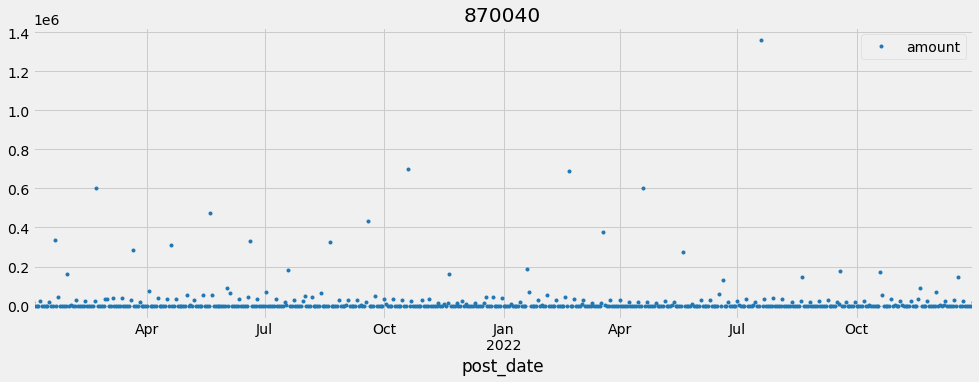

In [8]:
df.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='870040')
plt.show()

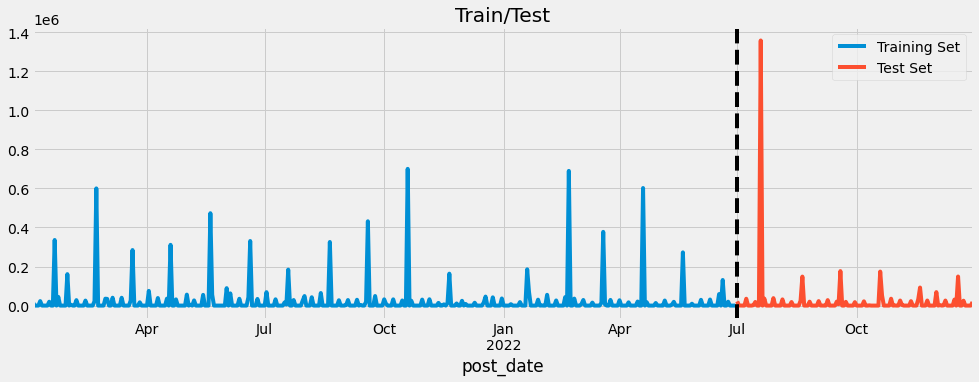

In [9]:
train = df.loc[df.index < '2022-07-01']
test = df.loc[df.index >= '2022-07-01']

fig, ax = plt.subplots(figsize=(15,5))

train.plot(label='X_train', title='Train/Test', ax=ax)
test.plot(label='y_train', ax=ax)
ax.axvline('2022-07-01', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

In [10]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

In [11]:
def add_lags(df):
    target_map = df['amount'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('5 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('15 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('25 days')).map(target_map)
    return df

## Build Baseline

In [12]:
def baseline(df, month_test: str, gr_adj = 1):
    gr_adj = gr_adj
    # get trend YoY|
    trend = df.loc['2022']['amount'].sum() / df.loc['2021']['amount'].sum()
    # adjust PY's number by trend
    py_month = df.loc['2021'+'-'+str(month_test)].sum()/trend
    avg_monthly = (py_month + df.loc['2022'+'-'+str(month_test)].sum()) / 2
    trend_min_1 = trend - 1
    value = avg_monthly * (1 + (trend_min_1 * gr_adj))
    return value, avg_monthly, trend_min_1

In [13]:
jan_base = baseline(df, '01')
jan_base

(amount    444763.868645
 dtype: float64,
 amount    478367.48161
 dtype: float64,
 -0.07024644077473052)

## Cross Val: sklearn

In [14]:
test_size = int(df.resample('M').count().mean())
tss = TimeSeriesSplit(n_splits=5, test_size=test_size, gap=0, max_train_size=415)

In [15]:
# for i, (train_index, test_index) in enumerate(tss.split(df)):
#     print(f"Fold {i}:")
#     print(f"  Train: index={train_index}")
#     print(f"  Test:  index={test_index}")

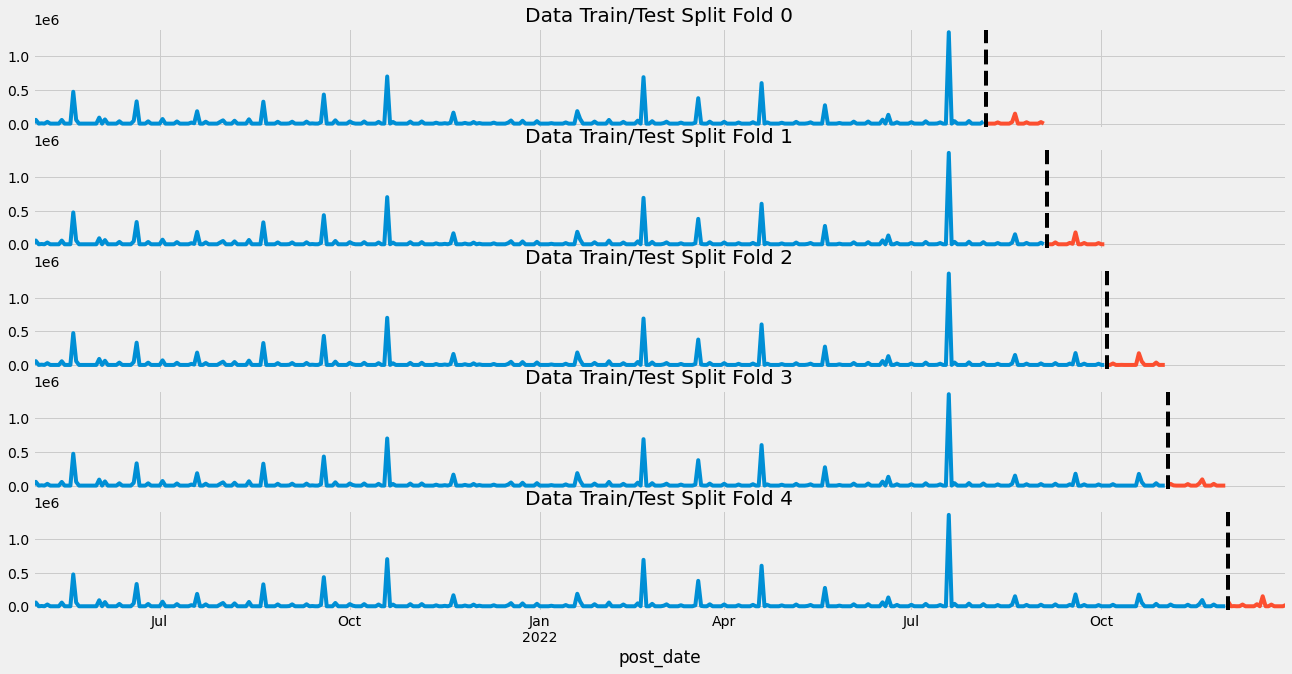

In [16]:
fig, axs = plt.subplots(5, 1, figsize=(20, 10), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['amount'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['amount'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

## Cross Val

In [17]:
folds = 0
preds = []
scores = []

for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    
    train = create_features(train)
    test = create_features(test)
    
    FEATURES = ['dayofyear', 'dayofweek', 'quarter', 'month','year']
    TARGET = 'amount'
    
    X_train, y_train = train[FEATURES], train[TARGET]
    X_test, y_test = test[FEATURES], test[TARGET]
    
    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           objective='reg:squarederror',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100,
            early_stopping_rounds=100
           )

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[0]	validation_0-rmse:108712.54688	validation_1-rmse:33656.37500
[100]	validation_0-rmse:100230.50000	validation_1-rmse:31897.36523
[155]	validation_0-rmse:90153.30469	validation_1-rmse:32114.04688
[0]	validation_0-rmse:107401.25000	validation_1-rmse:39620.73828
[100]	validation_0-rmse:97231.03125	validation_1-rmse:37374.30469
[200]	validation_0-rmse:87447.78125	validation_1-rmse:37377.92969
[300]	validation_0-rmse:79112.78906	validation_1-rmse:33524.38281
[400]	validation_0-rmse:73158.89062	validation_1-rmse:31581.71484
[500]	validation_0-rmse:66539.35156	validation_1-rmse:31128.61328
[600]	validation_0-rmse:61018.57422	validation_1-rmse:30786.74609
[700]	validation_0-rmse:55777.17188	validation_1-rmse:30529.00781
[800]	validation_0-rmse:51250.45703	validation_1-rmse:30363.77344
[900]	validation_0-rmse:47156.15625	validation_1-rmse:30273.57617
[999]	validation_0-rmse:43709.02734	validation_1-rmse:30249.09766
[0]	validation_0-rmse:103657.03906	validation_1-rmse:40658.03906
[100]	valida

In [18]:
print(f'Score across folds {np.mean(scores):0.2f}')
print(f'Fold scores:{scores}')

Score across folds 25187.83
Fold scores:[31611.191461655097, 30220.12707569727, 14473.767808364075, 15373.121926027768, 34260.95527598658]


## Predict the Future

In [19]:
# Retrain on all data

df = create_features(df)

FEATURES = ['dayofyear', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'amount'

X_all = df[FEATURES]
y_all = df[TARGET]

reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=500, # change with above results
                       objective='reg:squarederror',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100,
        early_stopping_rounds=100
       )

[0]	validation_0-rmse:98420.44531
[100]	validation_0-rmse:91937.38281
[200]	validation_0-rmse:85275.93750
[300]	validation_0-rmse:77313.28906
[400]	validation_0-rmse:68723.19531
[499]	validation_0-rmse:61797.51172


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=500, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

## Create future blank df

In [20]:
index = pd.bdate_range('2023-01-01', end='2023-01-31', freq='B')
future_df = pd.DataFrame(index=index)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df, future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

In [21]:
df_and_future.head()

,amount,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,isFuture,lag1,lag2,lag3
2021-01-04,16505.30,0,1,1,2021,4,4,1,False,NaN,NaN,NaN
2021-01-05,0.00,1,1,1,2021,5,5,1,False,NaN,NaN,NaN
2021-01-06,0.00,2,1,1,2021,6,6,1,False,NaN,NaN,NaN
2021-01-07,0.00,3,1,1,2021,7,7,1,False,NaN,NaN,NaN
2021-01-08,22898.37,4,1,1,2021,8,8,1,False,NaN,NaN,NaN


In [22]:
future_w_features = df_and_future.query('isFuture').copy()

In [23]:
future_w_features.head()

,amount,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,isFuture,lag1,lag2,lag3
2023-01-02,NaN,0,1,1,2023,2,2,1,True,0.00,NaN,1170.95
2023-01-03,NaN,1,1,1,2023,3,3,1,True,0.00,0.00,25757.22
2023-01-04,NaN,2,1,1,2023,4,4,1,True,18077.14,148818.26,NaN
2023-01-05,NaN,3,1,1,2023,5,5,1,True,NaN,0.00,NaN
2023-01-06,NaN,4,1,1,2023,6,6,1,True,NaN,0.00,0.00


In [24]:
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])

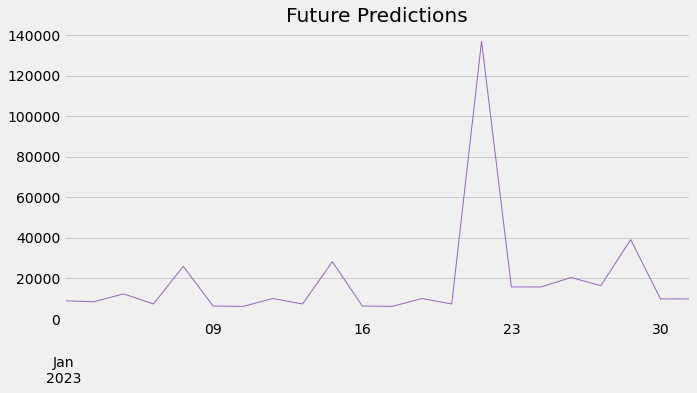

In [25]:
future_w_features['pred'].plot(figsize=(10, 5),
                               color=color_pal[4],
                               ms=1,
                               lw=1,
                               title='Future Predictions')
plt.show()

In [26]:
future_w_features['pred'].sum()

415889.3

In [27]:
x = 377659.53
x

377659.53

In [28]:
jan_base

(amount    444763.868645
 dtype: float64,
 amount    478367.48161
 dtype: float64,
 -0.07024644077473052)